In [1]:
import cv2
import mediapipe as mp
from matplotlib import pyplot as plt
import numpy as np
import os
import asyncio
from mediapipe.framework.formats import landmark_pb2
from keras.utils import to_categorical
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

2023-10-28 23:36:02.664547: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-28 23:36:03.517315: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [51]:
MAX_FRAMES = 120  # Defines the index of last frame need eg 120 means we get frames up until 120
FRAME_STEPS = 3     # Defines how often we get frames  eg 2 means we get 2,4,6.... frames

# If MAX_FRAMES = 120 and FRAME STEPS = 2 then we get 60 frames - 2,4,6,8..120

data_directory = 'preprocessed_data'

In [78]:
data_directory = 'preprocessed_data'

# Get a list of subdirectories (each representing a class)
class_directories = [os.path.join(data_directory, d) for d in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, d))]

# Initialize lists to store data, labels, and filenames
data_x = []
data_y = []
labels = []

# Iterate through each class directory
for class_dir in class_directories:
    # Get the class label from the directory name
    class_label = os.path.basename(class_dir)
    
    # Iterate through CSV files in the class directory
    for csv_file in os.listdir(class_dir):
        if csv_file.endswith('.csv'):
            # Load CSV data into a NumPy array
            csv_path = os.path.join(class_dir, csv_file)
            try:
                csv_data = np.genfromtxt(csv_path, delimiter=',')
            except ValueError as e:
                print(f"Error in file: {csv_path}")
                raise e
            
            # Check if the number of columns matches the expected 24
            if csv_data.shape[1] != 24:
                print(f"Error: {csv_path} has {csv_data.shape[1]} columns instead of 24")
                continue  # Skip this file if it doesn't have the expected number of columns
            
            # Truncate or pad data to match MAX_FRAMES
            if csv_data.shape[0] < MAX_FRAMES:
                csv_data = np.pad(csv_data, ((0, MAX_FRAMES - csv_data.shape[0]), (0, 0)), 'constant')
            else:
                csv_data = csv_data[:MAX_FRAMES, :]

            # Use step size to remove unnecessary frames
            csv_data = csv_data[::FRAME_STEPS]
            
            # Split the data into x and y
            x_data = csv_data[:, 0::2]  # Columns 0, 2, 4, ...
            y_data = csv_data[:, 1::2]  # Columns 1, 3, 5, ...
            
            # Append the data to the respective lists and add class label
            data_x.append(x_data)
            data_y.append(y_data)
            labels.append(class_label)

# Convert the lists to NumPy arrays
data_x = np.array(data_x)
data_y = np.array(data_y)

# Encode the class labels using LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)



In [79]:
targets_indexes = {class_name: encoded_label for encoded_label, class_name in enumerate(label_encoder.classes_)}

print(targets_indexes)

{'break': 0, 'evening': 1, 'five': 2, 'good': 3, 'stand': 4, 'time': 5}


In [80]:
print(data_x.shape)
print(data_y.shape) 

(639, 40, 12)
(639, 40, 12)


In [81]:
print(data_x)


[[[0.63436824 0.40656883 0.64762515 ... 0.39446187 0.6183393  0.40254384]
  [0.64306211 0.41087621 0.65587068 ... 0.40279311 0.62688684 0.41119784]
  [0.64331335 0.4100056  0.65768731 ... 0.40258697 0.62830335 0.4111779 ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.63220429 0.40277523 0.65531456 ... 0.39355847 0.62825572 0.400756  ]
  [0.63748676 0.40562141 0.65342617 ... 0.40251639 0.62822318 0.40916219]
  [0.63706452 0.40575099 0.65077811 ... 0.40253967 0.62575847 0.40979338]
  ...
  [0.62690705 0.40310922 0.67957479 ... 0.40012372 0.58470577 0.40069306]
  [0.62548321 0.40339351 0.66275489 ... 0.39796728 0.5829286  0.40183622]
  [0.62593347 0.40171644 0.65469569 ... 0.39712295 0.58446997 0.40437043]]

 [[0.62951529 0.37463889 0.65190983 ... 0.36650163 0.63010722 0.3759639 ]
  [0.61807227 0.378384

In [82]:
targets_cat = to_categorical(encoded_labels)
print(encoded_labels.shape)
print(targets_cat.shape)

(639,)
(639, 6)


In [95]:
# Divide into train and validation
TRAINSETSIZE = 500

random_indexes= np.random.permutation(639)

data_x_shuffled = data_x[random_indexes]
data_y_shuffled = data_y[random_indexes]
targets_shuffled = targets_cat[random_indexes]

data_x_train = data_x_shuffled[0:TRAINSETSIZE]
data_y_train = data_y_shuffled[0:TRAINSETSIZE]
targets_train = targets_shuffled[0:TRAINSETSIZE]

data_x_test = data_x_shuffled[TRAINSETSIZE:]
data_y_test = data_y_shuffled[TRAINSETSIZE:]
targets_test  = targets_shuffled[TRAINSETSIZE:]

print(data_x_test.shape, data_x_train.shape, targets_test.shape, targets_train.shape)


(139, 40, 12) (500, 40, 12) (139, 6) (500, 6)


In [97]:
from keras.models import Model
from keras import layers
from keras import Input

x_input = Input(shape=(int(MAX_FRAMES / FRAME_STEPS), 12), dtype='float32', name='x_coods')
encoded_x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x_input)
encoded_x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(encoded_x)
encoded_x = layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))(encoded_x)

y_input = Input(shape=(int(MAX_FRAMES / FRAME_STEPS), 12), dtype='float32', name='y_coods')
encoded_y = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(y_input)
encoded_y = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(encoded_y)
encoded_y = layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))(encoded_y)

concatenated = layers.concatenate([encoded_x, encoded_y], axis=-1)

pred = layers.Dense(64, activation='relu')(concatenated)
pred = layers.Dropout(.2)(pred)
pred = layers.Dense(128, activation='relu')(pred)
pred = layers.Dropout(.2)(pred)
pred = layers.Dense(128, activation='relu')(pred)
pred = layers.Dropout(.2)(pred)
pred = layers.Dense(len(targets_indexes.keys()), activation='softmax')(pred)

model= Model([x_input, y_input], pred)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

model.summary()


Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 x_coods (InputLayer)        [(None, 40, 12)]             0         []                            
                                                                                                  
 y_coods (InputLayer)        [(None, 40, 12)]             0         []                            
                                                                                                  
 bidirectional_26 (Bidirect  (None, 40, 128)              39424     ['x_coods[0][0]']             
 ional)                                                                                           
                                                                                                  
 bidirectional_29 (Bidirect  (None, 40, 128)              39424     ['y_coods[0][0]']      

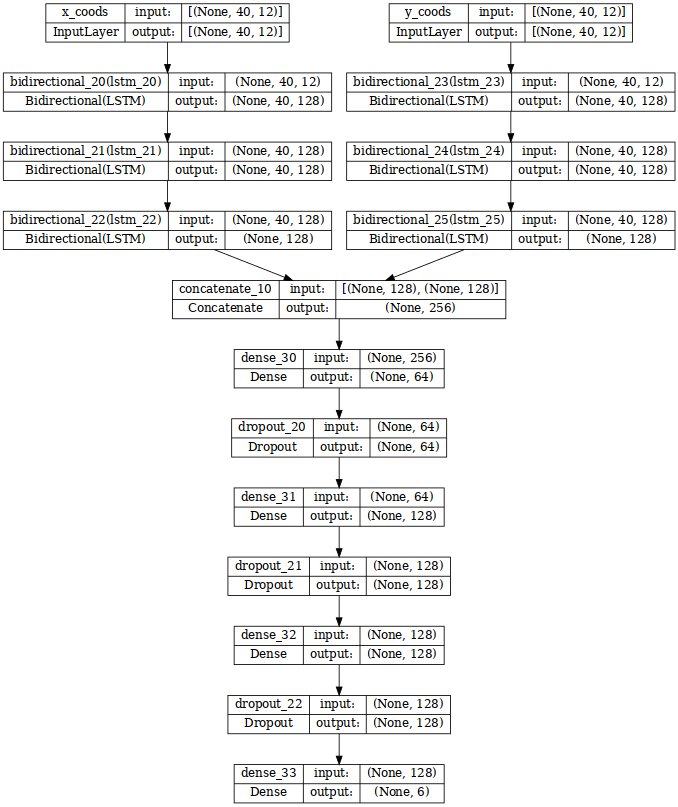

In [91]:
plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

In [98]:
history = model.fit([data_x_train, data_y_train], targets_train, epochs=60, validation_data=([data_x_test, data_y_test], targets_test))

Epoch 1/60
16/16 [==============================] - 46s 1s/step - loss: 1.7614 - acc: 0.2100 - val_loss: 1.7355 - val_acc: 0.2734
Epoch 2/60
16/16 [==============================] - 16s 1s/step - loss: 1.6771 - acc: 0.3020 - val_loss: 1.9959 - val_acc: 0.2662
Epoch 3/60
16/16 [==============================] - 17s 1s/step - loss: 1.4325 - acc: 0.4040 - val_loss: 1.2420 - val_acc: 0.4245
Epoch 4/60
16/16 [==============================] - 17s 1s/step - loss: 1.2369 - acc: 0.4400 - val_loss: 1.0067 - val_acc: 0.6403
Epoch 5/60
16/16 [==============================] - 16s 1s/step - loss: 1.1404 - acc: 0.5020 - val_loss: 1.0160 - val_acc: 0.5252
Epoch 6/60
16/16 [==============================] - 17s 1s/step - loss: 0.9948 - acc: 0.5860 - val_loss: 0.6769 - val_acc: 0.7410
Epoch 7/60
16/16 [==============================] - 17s 1s/step - loss: 0.9210 - acc: 0.5980 - val_loss: 0.7848 - val_acc: 0.6691
Epoch 8/60
16/16 [==============================] - 17s 1s/step - loss: 0.8293 - acc: 0.66

In [99]:
import matplotlib.pyplot as plt

def plotHist(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

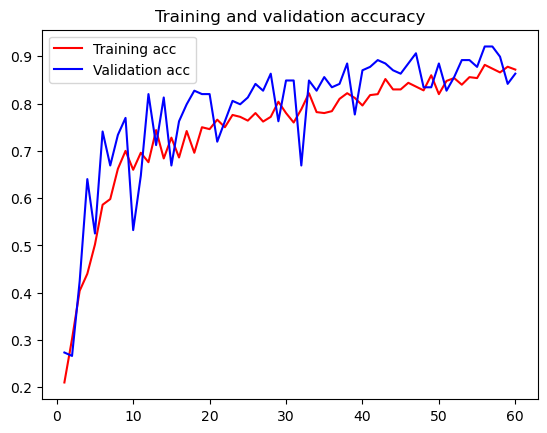

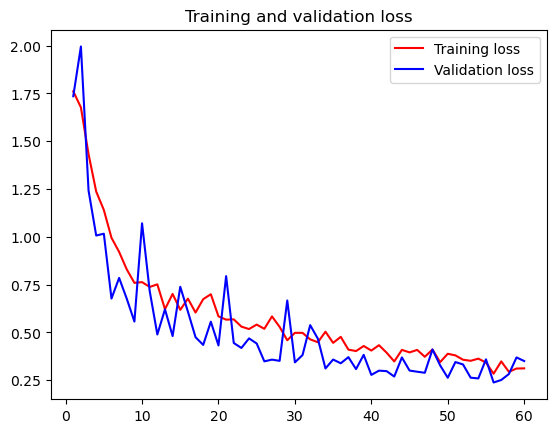

In [100]:
plotHist(history)

5/5 [==============================] - 2s 95ms/step
(139, 6)
[[21  0  0  0  3  0]
 [ 7 20  0  0  0  0]
 [ 0  0 19  1  0  3]
 [ 0  0  0 16  0  0]
 [ 4  0  0  0 12  0]
 [ 0  0  1  0  0 32]]


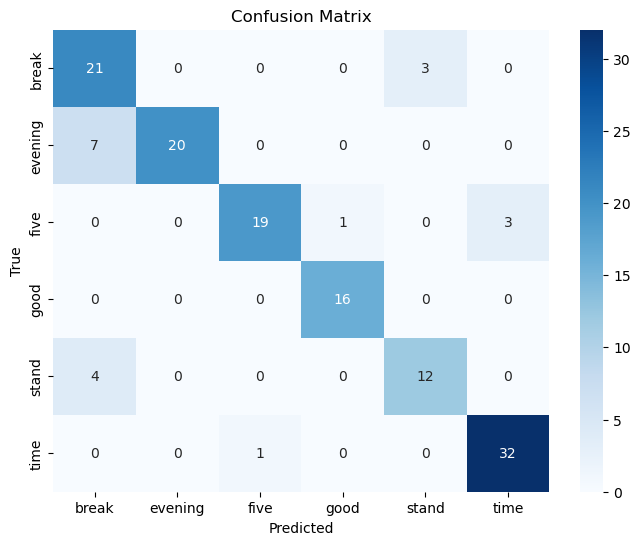

In [101]:

predicted_probabilities = model.predict([data_x_test, data_y_test])
print(targets_test.shape)
# Convert probabilities to class labels by taking the argmax
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Convert one-hot encoded target labels to class labels
true_labels = np.argmax(targets_test, axis=1)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)
print(confusion_mat)
class_names = list(targets_indexes.keys())
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [102]:
model.save("trained_models/six_class_model_4")

INFO:tensorflow:Assets written to: trained_models/six_class_model_4/assets


INFO:tensorflow:Assets written to: trained_models/six_class_model_4/assets
